In [1]:
import os
# os.environ["TRITON_INTERPRET"] = "1"

import triton
import torch
from torch import Tensor, nn
from typing import Dict, Optional
from math import ceil
import numpy as np
from torch.autograd import Function
from torch.autograd.function import Function
from functools import partial
import math
from copy import deepcopy
import triton.language as tl
from triton.tools.tensor_descriptor import TensorDescriptor

from triton_optimizers.optim.ops.rmsprop import rmsprop_interface, rmsprop_interface_torch

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(DEVICE)


cuda


In [2]:
os.environ["TRITON_PRINT_AUTOTUNING"] = "1"

## Adam

provider='torch', DTYPE=torch.float16, D=32,
provider='triton', DTYPE=torch.float16, D=32,
Autotuning kernel _adam_kernel with config BLOCK_SIZE: 16, num_warps: 4, num_ctas: 1, num_stages: 3, maxnreg: None
Autotuning kernel _adam_kernel with config BLOCK_SIZE: 32, num_warps: 4, num_ctas: 1, num_stages: 3, maxnreg: None
Autotuning kernel _adam_kernel with config BLOCK_SIZE: 64, num_warps: 4, num_ctas: 1, num_stages: 3, maxnreg: None
Autotuning kernel _adam_kernel with config BLOCK_SIZE: 128, num_warps: 4, num_ctas: 1, num_stages: 3, maxnreg: None
Autotuning kernel _adam_kernel with config BLOCK_SIZE: 256, num_warps: 4, num_ctas: 1, num_stages: 3, maxnreg: None
Autotuning kernel _adam_kernel with config BLOCK_SIZE: 512, num_warps: 4, num_ctas: 1, num_stages: 3, maxnreg: None
Autotuning kernel _adam_kernel with config BLOCK_SIZE: 1024, num_warps: 4, num_ctas: 1, num_stages: 3, maxnreg: None
Autotuning kernel _adam_kernel with config BLOCK_SIZE: 2048, num_warps: 4, num_ctas: 1, num_stages:

<Axes: title={'center': 'Adam'}, xlabel='D', ylabel='TFLOPS'>

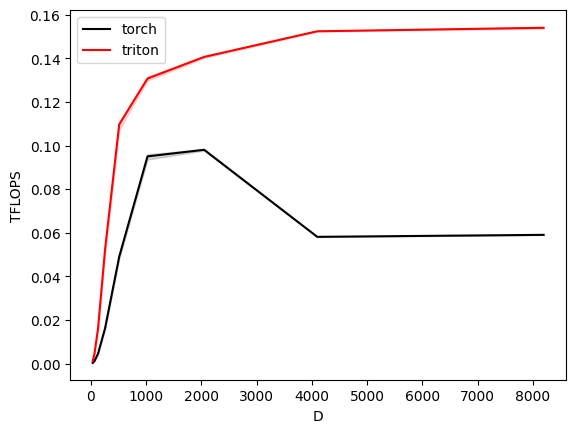

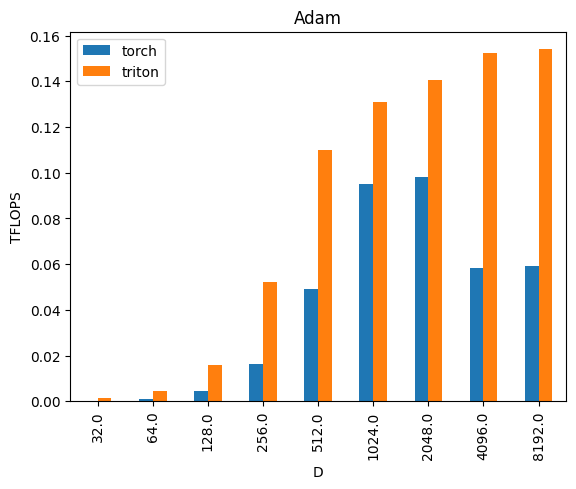

In [3]:
from triton_optimizers.optim.ops.adam import adam_interface, adam_interface_torch

MAP_FUN = {
    # "torch" : partial(rmsprop_torch, implace = False),
    "torch" : partial(adam_interface_torch, implace = True),
    "triton" : adam_interface,
    # "triton" : rmsprop,
}

names = list(MAP_FUN.keys())
available_colors = ["black", "red", "green", "blue", "yellow", "cyan", "purple", "grey"]
colors = available_colors[:len(MAP_FUN)]

def is_cuda():
    return triton.runtime.driver.active.get_current_target().backend == "cuda"

ref_lib = 'cuBLAS' if is_cuda() else 'rocBLAS'
TORCH_HAS_FP8 = hasattr(torch, "float8_e5m2")

configs = []
for fp8_inputs in [True]:
    configs.append(
        triton.testing.Benchmark(
            x_names=["D"],  # Argument names to use as an x-axis for the plot
            x_vals=[int(2 ** i) for i in np.arange(5, 14, 1)],  # Different possible values for `x_name`
            line_arg="provider",  # Argument name whose value corresponds to a different line in the plot
            line_vals=names, #["triton"] if fp8_inputs else [ref_lib.lower(), "triton"],  # Label name for the lines
            line_names=names, #["Triton"] if fp8_inputs else [ref_lib, "Triton"],  # Line styles
            styles=[(x, "-") for x, _ in zip(colors,names)], # ("green", "-"), ("blue", "-")],
            ylabel="TFLOPS",  # Label name for the y-axis
            plot_name="gated-mlp-performance",  # Name for the plot, used also as a file name for saving the plot.
            args={"fp8_inputs": fp8_inputs},
        ))

@triton.testing.perf_report(configs)
def benchmark(D, provider, fp8_inputs):
    
    DTYPE = torch.float16
    print(f"{provider=}, {DTYPE=}, {D=},")
    
    param = torch.rand(D, D).to(DEVICE)
    grad = torch.rand(D, D).to(DEVICE) 
    exp_avg = torch.rand(D, D).to(DEVICE) 
    exp_avg_sq = torch.rand(D, D).to(DEVICE) 

    fun = MAP_FUN[provider]
    kwargs = {
        "param" : param,
        "grad" : grad,
        "exp_avg" : exp_avg,
        "exp_avg_sq" : exp_avg_sq,
        "step": torch.tensor(1.).to(DEVICE), 
        "beta1" : 0.9,
        "beta2": 0.999,
    }
    quantiles = [0.5, 0.2, 0.8]
    ms, min_ms, max_ms = triton.testing.do_bench(lambda: fun(**kwargs), quantiles=quantiles) 
    perf = lambda ms: 18 * D * D * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)


df = benchmark.run(show_plots=False, print_data=True, return_df=True)[0]

df.plot.bar(x="D",ylabel="TFLOPS", xlabel="D", title="Adam")

## RMSprop

In [4]:
MAP_FUN = {
    # "torch" : partial(rmsprop_torch, implace = False),
    "torch" : partial(rmsprop_interface_torch, implace = True),
    "triton" : rmsprop_interface,
    # "triton" : rmsprop,
}

names = list(MAP_FUN.keys())
available_colors = ["black", "red", "green", "blue", "yellow", "cyan", "purple", "grey"]
colors = available_colors[:len(MAP_FUN)]

provider='torch', DTYPE=torch.float16, D=32,
provider='triton', DTYPE=torch.float16, D=32,
Autotuning kernel _rmsprop_kernel with config BLOCK_SIZE: 16, num_warps: 4, num_ctas: 1, num_stages: 3, maxnreg: None
Autotuning kernel _rmsprop_kernel with config BLOCK_SIZE: 32, num_warps: 4, num_ctas: 1, num_stages: 3, maxnreg: None
Autotuning kernel _rmsprop_kernel with config BLOCK_SIZE: 64, num_warps: 4, num_ctas: 1, num_stages: 3, maxnreg: None
Autotuning kernel _rmsprop_kernel with config BLOCK_SIZE: 128, num_warps: 4, num_ctas: 1, num_stages: 3, maxnreg: None
Autotuning kernel _rmsprop_kernel with config BLOCK_SIZE: 256, num_warps: 4, num_ctas: 1, num_stages: 3, maxnreg: None
Autotuning kernel _rmsprop_kernel with config BLOCK_SIZE: 512, num_warps: 4, num_ctas: 1, num_stages: 3, maxnreg: None
Autotuning kernel _rmsprop_kernel with config BLOCK_SIZE: 1024, num_warps: 4, num_ctas: 1, num_stages: 3, maxnreg: None
Autotuning kernel _rmsprop_kernel with config BLOCK_SIZE: 2048, num_warps: 4, 

<Axes: title={'center': 'RMSprop'}, xlabel='D', ylabel='TFLOPS'>

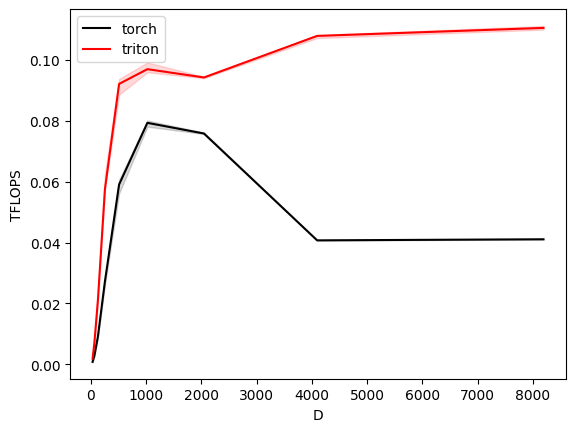

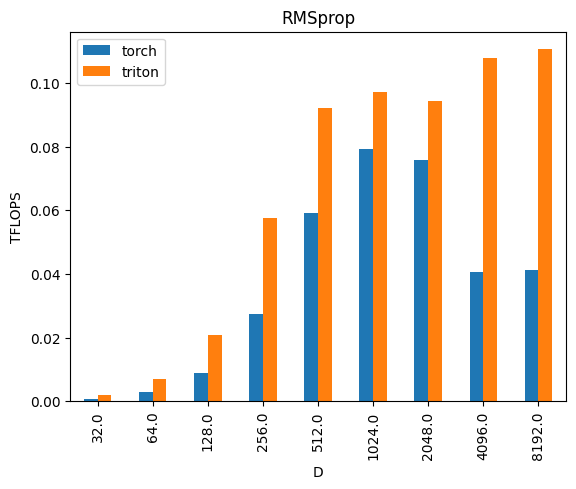

In [5]:

def is_cuda():
    return triton.runtime.driver.active.get_current_target().backend == "cuda"

ref_lib = 'cuBLAS' if is_cuda() else 'rocBLAS'
TORCH_HAS_FP8 = hasattr(torch, "float8_e5m2")

configs = []
for fp8_inputs in [True]:
    configs.append(
        triton.testing.Benchmark(
            x_names=["D"],  # Argument names to use as an x-axis for the plot
            x_vals=[int(2 ** i) for i in np.arange(5, 14, 1)],  # Different possible values for `x_name`
            line_arg="provider",  # Argument name whose value corresponds to a different line in the plot
            line_vals=names, #["triton"] if fp8_inputs else [ref_lib.lower(), "triton"],  # Label name for the lines
            line_names=names, #["Triton"] if fp8_inputs else [ref_lib, "Triton"],  # Line styles
            styles=[(x, "-") for x, _ in zip(colors,names)], # ("green", "-"), ("blue", "-")],
            ylabel="TFLOPS",  # Label name for the y-axis
            plot_name="gated-mlp-performance",  # Name for the plot, used also as a file name for saving the plot.
            args={"fp8_inputs": fp8_inputs},
        ))

@triton.testing.perf_report(configs)
def benchmark(D, provider, fp8_inputs):
    
    DTYPE = torch.float16
    print(f"{provider=}, {DTYPE=}, {D=},")
    
    param = torch.rand(D, D).to(DEVICE)
    grad = torch.rand(D, D).to(DEVICE) 
    square_avg = torch.rand(D, D).to(DEVICE) 

    fun = MAP_FUN[provider]
    kwargs = {
        "param" : param,
        "grad" : grad,
        "square_avg" : square_avg,
    }
    quantiles = [0.5, 0.2, 0.8]
    ms, min_ms, max_ms = triton.testing.do_bench(lambda: fun(**kwargs), quantiles=quantiles) 
    perf = lambda ms: 9 * D * D * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)


df = benchmark.run(show_plots=False, print_data=True, return_df=True)[0]

df.plot.bar(x="D",ylabel="TFLOPS", xlabel="D", title="RMSprop")